In [1]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing as mp
from threading import Thread
from math import erf
from scipy import optimize

c:\Users\digio\OneDrive\Documents\Francesco\Universita\Secondo Anno Magistrale\Online Learning Applications\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definition of the Nonstationary Environment 

In [2]:
class MultiProductPricingEnvironment:
    def __init__(self, products,
                 means,
                 covs,
                 seed=42,
                 plot_distribution=True,
                 T=None):
        self.products = products
        self.d = len(products)
        self.means, self.covs = self.delta_method_latent_from_logitnormal(means, covs)
        self.rng = np.random.default_rng(seed)
        self.cached_valuations = False

        if plot_distribution:
            n_samples = 100_000
            bins=100
            samples = self.sample_valuations(n_samples)
            for i, product in enumerate(products):

                plt.figure(figsize=(7, 3))
                plt.hist(samples[:, i], bins=bins, density=True)
                plt.title(f"Distribution of valuations for product {product} (100000 rounds)")
                plt.xlabel("valuation")
                plt.ylabel("density")
                plt.xlim(0, 1)
                plt.tight_layout()
                plt.show()

        if T is not None:
            self.valuations_samples = self.sample_valuations(T)
            self.cached_valuations = True
            self.i=0

    def compute_Q(self, prices_grid, eps = 1e-12):

        dvs = np.sqrt(np.clip(np.diag(self.covs), 0.0, None))

        pc = np.clip(prices_grid, eps, 1 - eps)
        logits = np.log(pc / (1 - pc))

        Phi = lambda x: 0.5 * (1.0 + np.vectorize(erf)(x / np.sqrt(2.0)))
        z = (logits[None, :] - self.means[:, None]) / np.where(dvs > 0, dvs, 1.0)[:, None]
        Q = 1.0 - Phi(z)

        Q[:, prices_grid <= 0.0] = 1.0
        Q[:, prices_grid >= 1.0] = 0.0

        # If there are determinist prices (zero variance), set the prices above the valuation to 0 and 1 below
        det = dvs == 0.0
        if np.any(det):
            v = 1.0 / (1.0 + np.exp(-self.means[det]))
            Q[det] = (v[:, None] >= prices_grid[None, :]).astype(float)
        return Q

    @staticmethod
    def delta_method_latent_from_logitnormal(m, C):
        """
        Approximate latent Gaussian parameters (mu, Sigma_Z) for a multivariate logit-normal
        with desired mean vector m in (0,1)^d and covariance C.

        Uses first-order delta method:
            J = diag( m_i * (1 - m_i) )
            Sigma_Z ≈ J^{-1} C J^{-1}
            mu ≈ logit(m)
        """
        m = np.asarray(m, dtype=float)
        C = np.asarray(C, dtype=float)
        if m.ndim != 1:
            raise ValueError("m must be a 1-D array of means in (0,1).")
        if C.shape != (m.size, m.size):
            raise ValueError("C must be a square matrix with same dimension as m.")
        if np.any((m <= 0) | (m >= 1)):
            raise ValueError("All entries of m must lie strictly in (0,1).")

        mu = logit(m)
        gprime = m * (1.0 - m)  # derivative of expit at mu where expit(mu)=m
        if np.any(gprime <= 0):
            raise ValueError("Means too close to 0 or 1 make the delta method unstable.")
        Jinv = np.diag(1.0 / gprime)
        Sigma_Z = Jinv @ C @ Jinv
        # Symmetrize small numerical asymmetry
        Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T)
        return mu, Sigma_Z

    def sample_valuations(self, n=1):
        if self.cached_valuations:
            self.i+=1
            return self.valuations_samples[self.i-1]
        z = self.rng.multivariate_normal(self.means, self.covs, size=n)
        if n==1:
            return expit(z).ravel()
        return expit(z)

    def round(self, chosen_prices):
        chosen_prices_arr = np.array([chosen_prices[p] for p in self.products], dtype=float)
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices_arr).astype(int)
        reward = np.multiply(chosen_prices_arr, sold)
        return sold, reward


In [19]:
class NonStationaryPricingEnvironment(MultiProductPricingEnvironment):
    def __init__(self, products, base_means, base_covs, T, volatility=0.05, seed=42, plot_distribution=False):
        """
        base_means : array-like, base expected valuations for each product
        base_covs  : array-like, base covariance matrix
        T          : total rounds
        volatility : amplitude of non-stationarity
        """
        super().__init__(products, base_means, base_covs, seed=seed, plot_distribution=False)
        self.T = T
        self.volatility = volatility
        self.base_means = np.array(base_means)
        self.base_covs = np.array(base_covs)
        self.time_idx = 0
        
        # Pre-generate a sequence of mean shifts and covariance shifts
        self.mean_shifts = self.rng.normal(0, volatility, size=(T, len(products)))
        # Optional: time-varying covariances (small random fluctuations)
        self.cov_shifts = np.array([self.base_covs * (1 + self.rng.normal(0, volatility, self.base_covs.shape))
                                    for _ in range(T)])
        self.trajectories = np.clip(self.base_means + np.cumsum(self.mean_shifts, axis=0), 0.01, 0.99)

    
    def sample_valuations(self, n=1):
        # Compute current-time mean and covariance
        t_mean = self.base_means + self.mean_shifts[self.time_idx]
        t_mean = np.clip(t_mean, 0.01, 0.99)  # keep within (0,1) for logit-normal
        
        t_cov = self.cov_shifts[self.time_idx]
        # Convert to latent Gaussian parameters using delta method
        mu, Sigma_Z = self.delta_method_latent_from_logitnormal(t_mean, t_cov)
        
        # Sample from multivariate normal and apply expit
        z = self.rng.multivariate_normal(mu, Sigma_Z, size=n)
        vals = expit(z)
        self.time_idx = min(self.time_idx + 1, self.T - 1)
        if n == 1:
            return vals.ravel()
        return vals

    def get_win_probabilities(self, t, prices):
        probs = {}
        for p_idx, p in enumerate(self.products):
            mu_t = self.trajectories[t, p_idx]
            probs[p] = np.clip(1 - prices[p] / max(1e-9, mu_t + 0.5), 0, 1)
        return probs

    def round(self, t, chosen_prices: dict, prices_dict):
        rewards, costs = {}, {}
        win_probs = self.get_win_probabilities(t, prices_dict)
        for p in self.products:
            prob = win_probs[p][np.argmin(np.abs(prices_dict[p] - chosen_prices[p]))]
            win = self.rng.binomial(1, prob)
            rewards[p] = chosen_prices[p] * win
            costs[p] = win
        return rewards, costs


### Definition of the Primal-Dual Agent

In [4]:
class EXP3PAgent:
    def __init__(self, K, T, alpha, gamma):
        self.K = K
        self.T = T
        self.alpha = alpha
        self.gamma = gamma
        self.a_t = None

        # Initialize weights
        self.weights = np.exp((self.alpha * self.gamma / 3) * np.sqrt(self.T / self.K)) * np.ones(self.K)
        self.probs = np.ones(self.K) / self.K
        self.t = 0
        self.N_pulls = np.zeros(self.K)


    def pull_arm(self):
        # Compute probability distribution
        self.probs = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        
        # Choose arm
        self.a_t = np.random.choice(np.arange(self.K), p=self.probs)
        return self.a_t

    def update(self, reward):
        self.t += 1
        self.N_pulls[self.a_t] += 1
        i = self.a_t
        
        # Unbiased reward estimator
        x_hat = np.zeros(self.K)
        x_hat[i] = reward / self.probs[i]
        
        # Bias correction
        x_hat[i] += self.alpha / (self.probs[i] * np.sqrt(self.K * self.T))
        
        # Update weights
        self.weights[i] *= np.exp((self.gamma / (3 * self.K)) * (x_hat[i]))


In [5]:
class PrimalDualPricingAgent:
    def __init__(self, products, prices, budget, T, eta, K):
        self.products = products
        self.prices = prices
        self.K = K
        self.budget = budget
        self.initial_budget = budget
        self.T = T
        self.eta = eta
        self.lmbd = 1.0  # Lagrange multiplier
        self.t = 0

        # One EXP3P agent per product
        self.agents = {p: EXP3PAgent(K=len(prices[p]), T=T,
                                     alpha=2*np.sqrt(K*T),
                                     gamma=min(3/5, 2 * np.sqrt((3*K*np.log(K))/(5*T))))
                       for p in products}

        # To track chosen indices for update
        self.price_indices = {p: 0 for p in products}

    def pull_prices(self):
        chosen_prices_idx = {}
        for p, agent in self.agents.items():
            if self.budget <= 0:
                chosen_prices_idx[p] = -1
            else:
                chosen_prices_idx[p] = agent.pull_arm()
        self.price_indices = chosen_prices_idx

        chosen_prices = {p: self.prices[p][idx] if idx >= 0 else 0
                         for p, idx in chosen_prices_idx.items()}
        return chosen_prices

    def update(self, rewards, costs):
        self.t += 1
        total_cost = sum(costs.values())

        # Dual update: increase λ if budget usage is high, decrease otherwise
        self.lmbd = max(0, self.lmbd - self.eta * (self.budget/self.T - total_cost))

        # Primal update per product
        for p, agent in self.agents.items():
            idx = self.price_indices[p]
            if idx >= 0:
                # Lagrangian reward: reward - λ * cost
                L = rewards[p] - self.lmbd * costs[p]
                agent.update(L)

        # Update remaining budget
        self.budget -= total_cost


### Baseline

In [6]:
def compute_clairvoyant_multi(products, prices, rho, win_probabilities, cost=0.0):
    """
    Compute the clairvoyant optimal pricing distribution for multiple products
    under a global budget constraint.

    Args:
        products: list of product names
        prices: dict of product -> array of candidate prices
        rho: max expected total number of units sold (global budget per round)
        win_probabilities: dict of product -> array of sale probabilities
        cost: optional cost per unit (default 0.0)

    Returns:
        gamma: dict of product -> optimal probability distribution over prices
        expected_reward: total expected reward
    """
    # Flatten decision variables
    all_prices = np.concatenate([prices[p] for p in products])
    all_win_probs = np.concatenate([win_probabilities[p] for p in products])

    # Objective: maximize expected profit
    c = - (all_prices - cost) * all_win_probs  # neg for linprog (minimization)

    # Budget constraint: total expected sales ≤ rho
    A_ub = [all_win_probs]
    b_ub = [rho]

    # Per-product normalization: sum_j γ_{p,j} = 1
    A_eq, b_eq = [], []
    start = 0
    for p in products:
        k = len(prices[p])
        row = np.zeros_like(all_prices)
        row[start:start+k] = 1.0
        A_eq.append(row)
        b_eq.append(1.0)
        start += k

    # Solve LP
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq,
                           bounds=(0, 1), method='highs')

    gamma = {}
    if res.success:
        start = 0
        for p in products:
            k = len(prices[p])
            gamma[p] = res.x[start:start+k]
            start += k
        expected_reward = -res.fun
    else:
        # Fallback: uniform distribution per product
        gamma = {p: np.ones(len(prices[p])) / len(prices[p]) for p in products}
        expected_reward = None

    return gamma, expected_reward

### Parallelization helper functions

In [22]:

def _progress_listener(q, n_trials, leave=False):
    """
    Render one tqdm bar per trial in the main process.
    Workers send ('init', trial_idx, total), ('update', trial_idx, n), ('close', trial_idx, 0).
    """
    bars = {}
    closed = set()
    while len(closed) < n_trials:
        msg = q.get()
        if msg is None:  # termination signal
            break
        kind, trial_idx, val = msg
        if kind == 'init':
            # Create the bar for this trial if not exists
            if trial_idx not in bars:
                bars[trial_idx] = tqdm(total=int(val),
                                       desc=f"Trial {trial_idx+1}",
                                       position=trial_idx,
                                       leave=leave)
        elif kind == 'update':
            if trial_idx in bars:
                bars[trial_idx].update(int(val))
        elif kind == 'close':
            if trial_idx in bars and trial_idx not in closed:
                bars[trial_idx].close()
                closed.add(trial_idx)

    # Ensure all bars are closed
    for tid, bar in bars.items():
        if tid not in closed:
            bar.close()

def _start_progress(n_trials, leave=False):
    mgr = mp.Manager()
    q = mgr.Queue()
    th = Thread(target=_progress_listener, args=(q, n_trials, leave), daemon=True)
    th.start()
    return q, th, mgr

# ----------------------------------------
# One trial (runs in a worker process)

def run_all_trials_parallel(seeds, products, prices, budget, T, eta, K, means, covs, n_jobs=-1, leave=False):
    progress_q, progress_thread, mgr = _start_progress(len(seeds), leave=leave)
    try:
        results = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(run_single_trial)(
                trial_idx, products, prices, budget, T, eta, K, means, covs, seed, progress_q
            )
            for trial_idx, seed in enumerate(seeds)
        )
    finally:
        # tell listener to exit if not already
        progress_q.put(None)
        progress_thread.join()
        mgr.shutdown()
    all_regrets = [np.cumsum(results[i][3]-results[i][0]) for i in range(len(results))]
    all_payments = [np.cumsum(results[i][2]) for i in range(len(results))]

    return all_regrets, all_payments


def run_single_trial(trial_idx, products, prices, budget, T, eta, K, means, covs, seed=42, progress_q=None):
    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    env = NonStationaryPricingEnvironment(products=products, base_means=means, base_covs=covs,
                                          seed=seed, T=T, plot_distribution=False)
    agent = PrimalDualPricingAgent(products, prices, budget, T, eta, K)
    rho = budget / T

    utilities = []
    clairv_util = []
    my_prices = []
    my_payments = []
    total_wins = 0

    for u in range(T):
        # Compute clairvoyant distribution with global budget constraint
        gamma, exp_clairv_util = compute_clairvoyant_multi(products, prices, rho,
                                                           env.get_win_probabilities(u, prices))
        clairv_util.append(exp_clairv_util)

        # Agent chooses prices per product
        chosen_prices = agent.pull_prices()

        # Environment interaction
        rewards, costs = env.round(u, chosen_prices, prices)   # <-- must return dicts {p: reward}, {p: cost}
        agent.update(rewards, costs)

        # Logging
        utilities.append(sum(rewards.values()))
        my_prices.append(chosen_prices)
        my_payments.append(sum(costs.values()))
        total_wins += sum(costs.values())

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    print(f"Total # of Wins: {total_wins}")

    if progress_q is not None:
        progress_q.put(('close', trial_idx, 0))

    return (
        np.array(utilities),
        my_prices,                    # list of dicts of prices
        np.array(my_payments),
        np.array(clairv_util)
    )



In [23]:
products = ['A','B','C']
budget = 6000
T = 6000
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,123567]

epsilon = T ** (-0.33)
K = int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
prices = {p: prices_per_product for p in products}

means = np.array([0.1, 0.5, 0.8])
covs = 0.001*np.array([[1., 0., 0.],
                       [0., 2., 0.],
                       [0., 0., 0.5]])

eta = T**(-0.5)   # 🔥 choose a learning rate for λ (important!)

# Run in parallel
all_regrets, all_payments = run_all_trials_parallel(
    seeds, products, prices, budget, T, eta, K, means, covs, n_jobs=-1
)

# Pad regrets to equal length
all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
avg_regret = all_regrets.mean(axis=0)
regret_std = all_regrets.std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)


Discretizing prices with 17 values


Trial 1:   0%|          | 0/6000 [00:00<?, ?it/s]





Trial 1:   0%|          | 9/6000 [00:00<01:07, 89.19it/s]










Trial 1:   0%|          | 26/6000 [00:00<00:44, 132.96it/s]














Trial 1:   1%|          | 41/6000 [00:00<00:42, 139.52it/s]














Trial 1:   1%|          | 55/6000 [00:00<00:43, 136.40it/s]














Trial 1:   1%|          | 72/6000 [00:00<00:41, 143.78it/s]




















Trial 1:   1%|▏         | 87/6000 [00:00<00:42, 137.72it/s]




















Trial 1:   2%|▏         | 102/6000 [00:00<00:44, 133.08it/s]




















Trial 1:   2%|▏         | 118/6000 [00:00<00:42, 139.42it/s]




















Trial 1:   2%|▏         | 133/6000 [00:00<00:45, 130.16it/s]




















Trial 1:   3%|▎         | 153/6000 [00:01<00:39, 147.90it/s]




















Trial 1:   3%|▎         | 169/6000 [00:01<00:39, 145.83it/s]


























Trial 1:   3%|▎         | 184/6000 [00:01<00:52, 111.11it/s]

























<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_6204\267946643.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


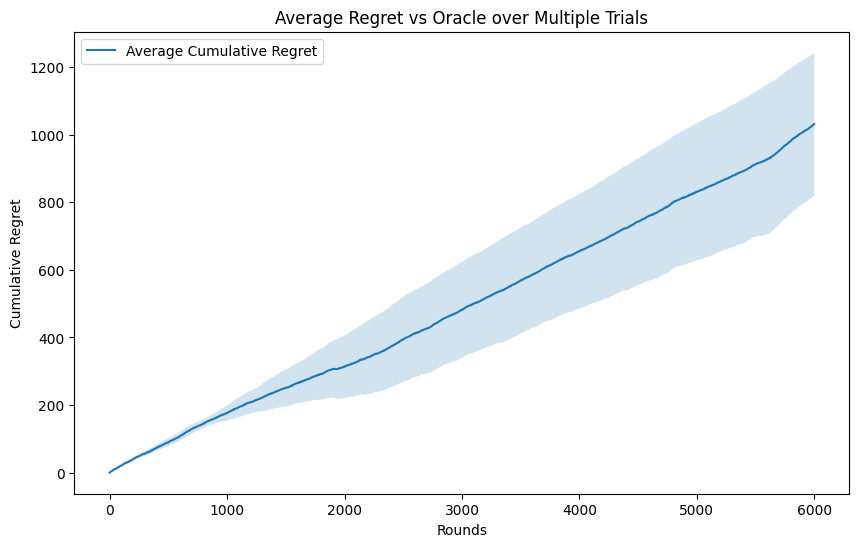

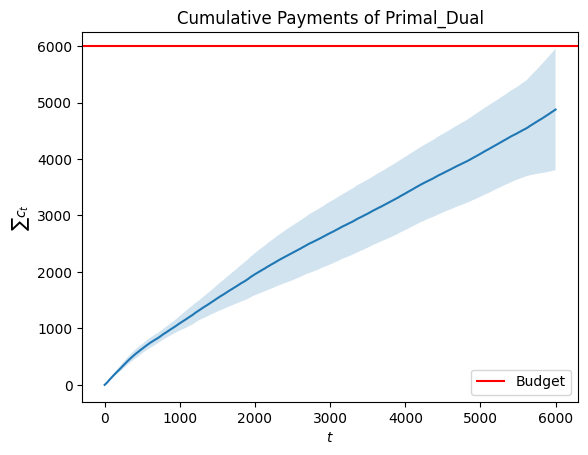

In [25]:
plt.figure(figsize=(10,6))
plt.plot(avg_regret, label='Average Cumulative Regret')
plt.fill_between(range(T), avg_regret-regret_std, avg_regret+regret_std, alpha=0.2)
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Average Regret vs Oracle over Multiple Trials')
plt.legend()
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.2)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Primal_Dual')
plt.show()